# Monte Carlo visualization sandbox

Configured for remote Jupyter access on Graham

***

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm

%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 12})

***

### Process Monte Carlo

Parameters

In [5]:
# Results path
results_path = '/scratch/dlatorne/MIDOSS/runs/monte-carlo'

# Slicing and plotting params
hours = 72
zlevel = 39
jmin, jmax = 400, 800
imin, imax = 110, 350
threshold = 0

# Slicing and plotting variables
x, y = np.arange(imin, imax), np.arange(jmin, jmax)
slc = {
    'time': slice(None, hours),
    'grid_z': zlevel,
    'grid_y': slice(jmin, jmax),
    'grid_x': slice(imin, imax),
}

# NEMO meshmask
mask = xr.open_dataset('/home/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
tmask = mask.tmask[0, 0, jmin:jmax, imin:imax]

Run sets

In [6]:
# Define runset lists
runsets = [
    'northern_strait_first30',
    'north_strait_2nd60',
    'north_strait_3rd150',
    'north_strait_4th122',
]

timestamps = [
    '2021-06-11T202428',
    '2021-06-12T141330',
    '2021-06-12T201317',
    '2021-06-13T143859',
]

nruns = [30, 60, 150, 122]

Determine presence above threshold and calculate PDF

In [7]:
# Collect individual runs across all run sets
results = []
for runset, timestamp, n in zip(runsets, timestamps, nruns):
    for run in tqdm(range(n)):
        
        # Construct path and load into Xarray Dataset
        runpath = f'{results_path}/{runset}_{timestamp}/results/{runset}-{run}'
        oiltype = glob(f'{runpath}/Lagrangian*')[0].split('/')[-1].split('_')[1].split('-')[0]
        fn = f'{runpath}/Lagrangian_{oiltype}-{run}_{runset}-{run}.nc'
        with xr.open_dataset(fn) as ds:
            
            # Determine grid cells containing oil above the threshold at all hours
            presence = ds.OilConcentration_3D.isel(slc).values > threshold
            
            # Sum across all hours and render as bool to assign presence/absence for entire duration
            presence = presence.sum(axis=0).astype(bool)
            
            # Add a concatenation dimension and append to results list
            results.append(presence[None, ...])

# Calculate PDF
PDF = np.concatenate(results).mean(axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

***

### Visualization

Plot PDF

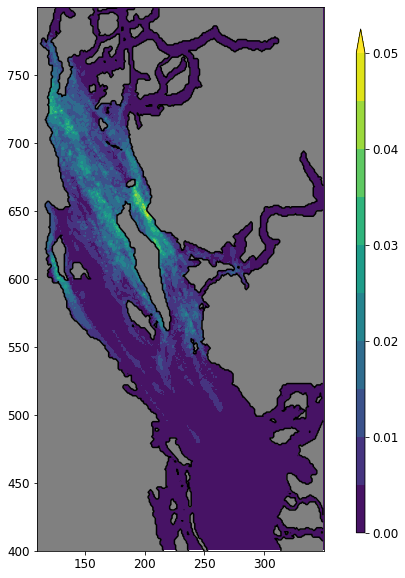

In [19]:
# Plot PDF
fig, ax = plt.subplots(figsize=(6, 10))
c = ax.contourf(x+0.75, y+0.75, PDF, levels=np.arange(0, 0.051, 0.005), extend='max')
ax.contourf(x, y, tmask, levels=[-0.01, 0.01], colors='Gray')
ax.contour(x, y, tmask, levels=[-0.01, 0.01], colors='k')
ax.set_aspect(5/4.4)
        
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cax)

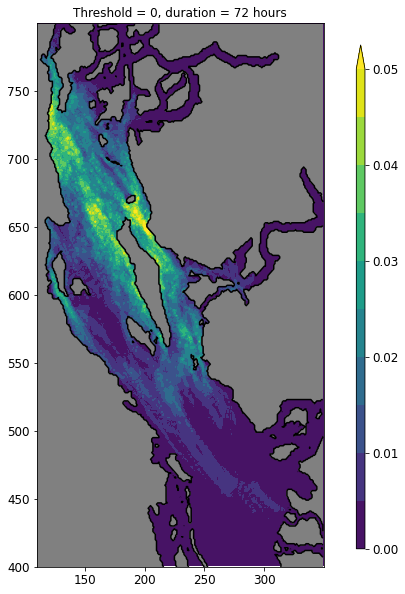

In [10]:
# Plot PDF
fig, ax = plt.subplots(figsize=(6, 10))
c = ax.contourf(x+0.75, y+0.75, PDF, levels=np.arange(0, 0.051, 0.005), extend='max')
ax.contourf(x, y, tmask, levels=[-0.01, 0.01], colors='Gray')
ax.contour(x, y, tmask, levels=[-0.01, 0.01], colors='k')
ax.set_aspect(5/4.4)
ax.set_title('Threshold = 0, duration = 72 hours')
        
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cax)